In [1]:
from fastai.vision.all import *
import torchaudio

In [2]:
df_train = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/train.csv')
df_test = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/test.csv')
submission = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/sample_submission.csv')

In [3]:
train_path = Path('/home/ubuntu/.kaggle/resampled/resampled_train/')
test_path = Path('/home/ubuntu/.kaggle/resampled/resampled_test/')

In [4]:
train_files = get_files(train_path, extensions='.wav')


In [5]:
train_files

(#19909) [Path('/home/ubuntu/.kaggle/resampled/resampled_train/018663_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/008647_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/018904_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/001706_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/003820_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/013023_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/009569_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/017429_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/008264_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/000141_16k.wav')...]

In [6]:
def get_y(filename):
    resample_name = filename.name.split('_')[0] + '.ogg'
    return df_train[df_train['filename']==resample_name]['genre'].values[0]

In [7]:
get_y(train_files[0])


'Chiptune / Glitch'

In [8]:
# Excluded unusual music thanks to this thread: https://www.kaggle.com/c/kaggle-pog-series-s01e02/discussion/312842
def get_items(path): 
    excluded_files = ["010449_16k.wav" , "005589_16k.wav" , "004921_16k.wav", "019511_16k.wav" , "013375_16k.wav" , "024247_16k.wav", "024156_16k.wav"]
    items = get_files(path, extensions='.wav')
    items = [item for item in items if item.name not in excluded_files]
    
    ## For fast iteration
#     items = [item for item in items if get_y(item) in ['Punk', 'Rock']]
    
#     items.shuffle()
    return L(items)

In [9]:
N_FFT = 2048
HOP_LEN = 512

In [10]:
filename = train_files[0]


In [11]:
filename.name.split('_')[0] + '.ogg'


'018663.ogg'

In [12]:
def create_spectrogram(filename):
    audio, sr = torchaudio.load(filename)
    specgram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
                                                    n_fft=N_FFT, 
                                                    win_length=N_FFT, 
                                                    hop_length=HOP_LEN*2,
                                                    center=True,
                                                    pad_mode="reflect",
                                                    power=2.0,
                                                    norm='slaney',
                                                    onesided=True,
                                                    n_mels=128,
                                                    mel_scale="htk"
                                                   )(audio)[0]
    specgram = torchaudio.transforms.AmplitudeToDB()(specgram)
    specgram = specgram - specgram.min()
    specgram = specgram/specgram.max()*255
    
    
    return specgram

In [13]:
filename = train_files[0]
spec_default = create_spectrogram(filename)

In [14]:
spec_default.shape


torch.Size([128, 469])

In [15]:
items = get_items(train_path)
labels = [get_y(item) for item in items]
Counter(labels)

Counter({'Chiptune / Glitch': 1180,
         'International': 814,
         'Punk': 2581,
         'Hip-Hop': 1755,
         'Ambient Electronic': 796,
         'Electronic': 3071,
         'Folk': 1213,
         'Country': 142,
         'Rock': 3095,
         'Experimental': 1799,
         'Pop': 945,
         'Instrumental': 1043,
         'Classical': 495,
         'Old-Time / Historic': 408,
         'Jazz': 306,
         'Spoken': 94,
         'Soul-RnB': 94,
         'Blues': 58,
         'Easy Listening': 13})

In [16]:
splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=labels)

In [17]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_items,
    get_x=create_spectrogram,
    get_y=get_y,
    splitter=splitter,
    item_tfms=[Resize(128)],
    batch_tfms=aug_transforms(max_rotate=0, max_warp=0,size=128))

In [18]:
dls = db.dataloaders(train_path, bs=64)

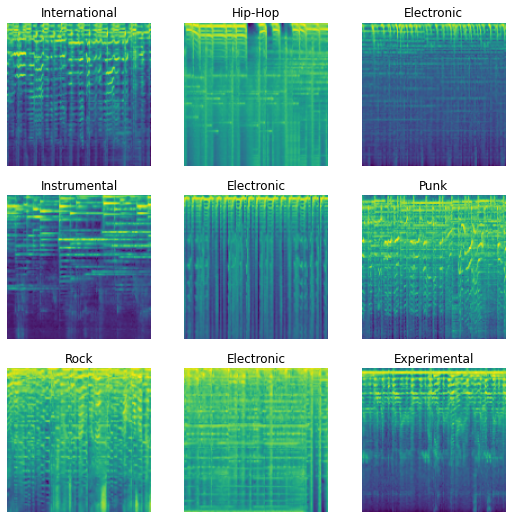

In [19]:
dls.show_batch()


In [20]:
mixup = MixUp(0.4)

In [21]:
model = model = partial(xse_resnet18, pool=MaxPool)

In [22]:
learn = cnn_learner(dls, 
                    model, 
                    metrics=[accuracy, F1Score(average='micro')], 
                    pretrained=False, 
                    loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=ranger, 
                   )

In [23]:
learn.to_fp16()


In [24]:
## This is to make model works with 1-channel input
def alter_learner(learn, channels=1):
    learn.model[0][0][0].in_channels=channels
    learn.model[0][0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0][0].weight[:,1,:,:].unsqueeze(1))

In [25]:
nchannels = dls.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

In [26]:
# learn.lr_find()

In [27]:
learn.fit_flat_cos(40, 0.003, cbs=[mixup, CSVLogger(), SaveModelCallback()])


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.884693,2.366258,0.322613,0.322613,02:16
1,2.449520,2.114351,0.389950,0.389950,02:14
2,2.307052,2.135356,0.383920,0.383920,02:14
3,2.241428,2.227037,0.345980,0.345980,02:15
4,2.194857,1.954057,0.435176,0.435176,02:14
5,2.155707,1.991287,0.424121,0.424121,02:14
6,2.144796,2.002288,0.431910,0.431910,02:14
7,2.151387,1.872925,0.463819,0.463819,02:14
8,2.136594,1.876935,0.470603,0.470603,02:14
9,2.079542,1.919536,0.468593,0.468593,02:13


Better model found at epoch 0 with valid_loss value: 2.366258144378662.
Better model found at epoch 1 with valid_loss value: 2.1143510341644287.
Better model found at epoch 4 with valid_loss value: 1.9540565013885498.
Better model found at epoch 7 with valid_loss value: 1.8729249238967896.
Better model found at epoch 10 with valid_loss value: 1.8298500776290894.
Better model found at epoch 13 with valid_loss value: 1.8175232410430908.
Better model found at epoch 16 with valid_loss value: 1.8165464401245117.
Better model found at epoch 17 with valid_loss value: 1.8048114776611328.
Better model found at epoch 19 with valid_loss value: 1.765193223953247.
Better model found at epoch 22 with valid_loss value: 1.7625737190246582.
Better model found at epoch 28 with valid_loss value: 1.7542123794555664.
Better model found at epoch 29 with valid_loss value: 1.741770625114441.
Better model found at epoch 31 with valid_loss value: 1.7165242433547974.
Better model found at epoch 34 with valid_los

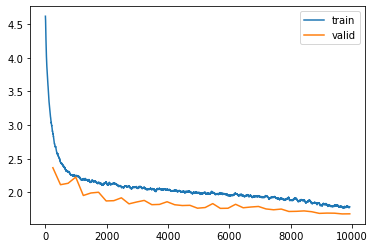

In [28]:
learn.recorder.plot_loss()


In [29]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)

True

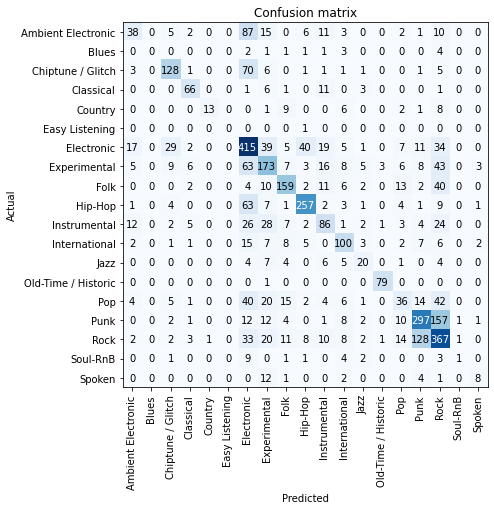

In [30]:
interp.plot_confusion_matrix(figsize=(7,7))


In [31]:
def genreid_from_genre(genre):
    return int(genre2id[genre2id['genre'] == genre]['genre_id'].values[0])

In [32]:
filename.name.split('_')[0]


'018663'

In [33]:
test_items = get_items(test_path)
test_dl = dls.test_dl(test_items)
preds = learn.get_preds(dl=test_dl)
preds_idx = preds[0].argmax(axis=1)
genre2id = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/genres.csv')
songid_preds = {int(file_path.name.split('_')[0]):genreid_from_genre(learn.dls.vocab[_id]) for file_path, _id in zip(test_items,preds_idx)}
submission['genre_id'] = submission['song_id'].map(songid_preds)
submission['genre_id'].fillna(0, inplace=True)
submission.genre_id = submission.genre_id.astype(int)
submission.to_csv(f"submission_{int(time.time())}.csv", index=False)